# Basic properties of Hermite polynomials 

We use the recursive Hermite polynomial defintion 
$$
He_0(x)=1, \qquad He_1(x)=x, \qquad He_k(x) = x He_{k-1}(x) - (k-1) He_{k-2}(x)
$$
and normalized Hermite 
$$
he_k(x) = \frac{1}{\sqrt{k!}}He_k(x) 
$$
**Orthogonality of Hermite polynomials:**
$$
E_{X\sim N(0,1)} [He_k(X) He_l(x)]= k! \delta_{kl},\qquad 
E_{X\sim N(0,1)} [he_k(X) he_l(x)]= \delta_{kl}
$$
where $\delta$ is Dirac delta, and also its normalized version. 

*Expansion in Hermite basis:* Based on orthognoality, we can expand in the normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k he_k(x), \qquad c_k = E_{X\sim N(0,1)}f(X)he_k(X)
$$
and not normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k He_k(x), \qquad c_k = \frac{1}{k!} E_{X\sim N(0,1)}f(X)He_k(X) 
$$



**Kernel map**
If $X,Y$ are standard Gaussian with covariance $\rho,$ we define the kernel map $f$, as 
$$
\kappa_f(\rho) := E_{X,Y} f(X)f(Y) \qquad X,Y\sim N(0,1), E XY=\rho
$$
- Thus, in the normalized Hermite basis we have
$$
\kappa_f(\rho)=\sum_{k=0}^\infty c_k^2 \rho^k, \qquad f(x)=\sum_{k=0}^\infty c_k he_k(x), 
$$
Basic properties of kernel map:
- in the normalized basis we have
$$
E f(X) = c_0 = \sqrt{\kappa(0)}, \qquad E f(X)^2 = \sum_{k=0}^\infty c_k^2 = \kappa(1),  
$$



In [3]:
from utils import * 

figures_path = '../paper/figures/'
# uncomment to test the basic properties of Hermite polynomials 
# run_tests()

# Validating theorems  of global convergence paper

In [4]:

def get_activation_indicators(activation, order=25, rho0=0, tol = 1e-4):
    """
    Calculate important indicators for an activation function.
    
    Parameters:
    activation (str or np.array): Activation function name or Hermite coefficients
    order (int): Order of Hermite expansion (if activation is a string)
    rho0 (float): Initial correlation value for fixed point iteration
    
    Returns:
    dict: A dictionary containing important statistics
    """
    if isinstance(activation, str):
        f = get_activation_function(activation)
        coefs = compute_hermite_coefs_integration(f, order=order)
    else:
        coefs = activation
        activation = "custom"
    
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs_normalized = coefs / norm_coef
    
    kappa = kernel_map(coefs_normalized)
    kappa_prime = kernel_map(coefs_normalized, 1)
    
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]
    
    k0 = kappa(0)
    k_prime_star = kappa_prime(rho_star)
    k_prime_1 = kappa_prime(1)
    k_prime_0 = kappa_prime(0)

    
    # Determine the convergence case
    if abs(k0) < tol:
        case = '1'
        alpha = 1/(2-k_prime_0)
        bound = r'\frac{|\rho|}{(1 - |\rho_0| + |\rho_0| A^\ell}'
    else:
        if k_prime_1 < 1-tol:
            case = '2'
            alpha = k_prime_1
            bound = r'|\rho_0-R| A^\ell'
            bound.replace
        elif abs(k_prime_1-1) < tol:
            case = '3'
            alpha = k0+k_prime_0
            bound = r'\frac{|\rho_0-R|}{\ell (1-A) |\rho_0-R| + 1}'
        else:
            case = '4'
            alpha1 = (1-rho_star)/(2-k_prime_star)
            alpha2 = k_prime_star
            alpha3 = 1-k0
            alpha = max([alpha1,alpha2,alpha3])
            bound = r'\frac{|\rho_0-R|A^\ell}{1 - |\rho_0| + |\rho_0|A^\ell}'
    # bound = bound.replace('A', f'{alpha:.2f}')
    # bound = bound.replace('R', f'{rho_star:.2f}')
    bound = bound.replace('A', r'\alpha')
    bound = bound.replace('R', r'\rho_\star')
    
    return {
        r"$\phi$": f'{activation}',
        r"$C=\E\phi(X)^2$": norm_coef,
        r"$\alpha$": alpha,
        r"$\rho_\star$": rho_star,
        r"\kappa_\phi(\rho_\star)$": kappa(rho_star),
        r"\kappa_\phi(0)$": kappa(0),
        r"\kappa_\phi'(0)$": k_prime_0,
        r"\kappa_\phi'(1)$": k_prime_1,
        r"\kappa_\phi'(\rho*)$": k_prime_star,
        r"\text{Case}": case,
        "hermite_coefs": coefs,
    }



def calculate_convergence_params(kappa, kappa_prime, rho0, tol=1e-4, layers=30):
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]
    rhos = rhos[:layers]
    ls = np.arange(len(rhos))

    k0 = kappa(0)
    k_prime_star = kappa_prime(rho_star)
    k_prime_1 = kappa_prime(1)
    k_prime_0 = kappa_prime(0)


    if abs(k0) < tol:
        case = 'case 1'
        x0 = abs(rho0-rho_star)
        alpha = 1/(2-k_prime_0)
        bound = x0 * alpha**ls / (1-x0 + x0 * alpha**ls)
    else:
        if k_prime_1 < 1-tol:
            case = 'case 2'
            alpha = k_prime_1
            bound = abs(rho0-rho_star) * alpha**ls
        elif abs(k_prime_1-1) < tol:
            case = 'case 3'
            alpha = k0+k_prime_0
            bound = abs(rho0-rho_star) / (ls * (1-alpha) * abs(rho0-rho_star) + 1)
        else:
            case = 'case 4'
            alpha1 = (1-rho_star)/(2-k_prime_star)
            alpha2 = k_prime_star
            alpha3 = 1-k0
            alpha = max([alpha1,alpha2,alpha3])
            bound = (abs(rho0-rho_star) * alpha**ls) / (1 - abs(rho0) + abs(rho0) * alpha**ls)
    return rhos, rho_star, bound, case


def plot_kernel_convergence(ax, kappa, kappa_prime, rho0, tol=1e-4, layers=30, plot_type='bound'):
    rhos, rho_star, bound, case = calculate_convergence_params(kappa, kappa_prime, rho0, tol, layers)
    
    # plt.figure(figsize=(10, 6))
    
    if plot_type == 'convergence':
        ax.plot(rhos, marker='.', label='empirical $\\rho_\\ell$')
        sign, B = (1, 'upper') if rhos[0] > rho_star else (-1, 'lower')
        ax.plot(rho_star + sign * bound, '-', marker='.', color='red', label=f'{B} bound ({case})')
        ax.axhline(rho_star, linestyle='--', color='black', label='$\\rho^*$')
        ax.set_ylim(-1,1.1)
        ax.set_ylabel('$\\rho$')
        ax.set_title('Convergence towards $\\rho^*$')
    elif plot_type == 'bound':
        ax.plot(np.abs(rhos-rho_star), marker='.',label='empirical $|\\rho_\\ell - \\rho^*|$')
        ax.plot(bound, '--', color='red', marker='.',label=f'theory ({case})')
        ax.set_ylabel('$|\\rho_\\ell-\\rho^*|$')
        # ax.set_ylim(-0.1,1.1*max(np.abs(rhos-rho_star)))
        ax.set_yscale('log')
        ax.set_title('Distance towards $\\rho^*$')
    
    ax.set_xlabel('$\\ell$')
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def act_conf2name(act_conf, tol=1e-2):
    if isinstance(act_conf, str):
        # Case 1: Activation name with default parameters
        name = act_conf
    elif isinstance(act_conf, np.ndarray):
        # Case 2: Hermite coefficients directly provided
        coefs = act_conf
        coefs = [f"{' +' if c > 0 else ' -'}{abs(c):.2f} \\he_{k}" for k,c in enumerate(coefs) if abs(c)>tol]
        name = "".join(coefs)
    elif isinstance(act_conf, dict):
        # Case 3: Config dictionary with custom parameters
        act_name = act_conf.get('name')
        del act_conf['name']
        args = [f"{k}={v}" for k,v in act_conf.items()]
        args = ','.join(args)
        name = f'{act_name}({args})'
    return name


def plot_activation_analysis(axes, f_norm, coefs, kappa, kappa_prime, rho0, act_conf,tol=1e-2):
    plot_activation(axes[0], f_norm, act_conf=act_conf, a=-3, b=3, )
    plot_fixed_point_iteration(axes[1], kappa, rho0, -1, 1, kernel_name='\\kappa_\\phi(\\rho)', )
    plot_kernel_convergence(axes[2], kappa, kappa_prime, rho0, tol=tol, layers=100, plot_type='convergence',)
    plot_kernel_convergence(axes[3], kappa, kappa_prime, rho0, tol=tol, layers=100, plot_type='bound',)

def plot_activation(ax, f, act_conf, a=-3, b=3,):
    x = np.linspace(a, b, 1000)
    ax.plot(x, f(x), label='\phi', linewidth=2)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'$\\phi = {act_conf2name(act_conf)}$', fontsize=14)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_fixed_point_iteration(ax, func, rho0, a=-1, b=1, tol=1e-5, max_iterations=1000, kernel_name='\\kappa_\\phi(\\rho)'):
    x_values = fixed_point_iteration(func, rho0, tol=tol, max_iterations=max_iterations)
    x = np.linspace(a, b, 1000)
    
    ax.plot(x, func(x), label=f'${kernel_name}$', color='blue', linewidth=2)
    ax.plot(x, x, label='identity', color='black', linestyle='--', linewidth=1.5)
    for i in range(1, len(x_values)):
        if i==1:
            ax.plot([x_values[0], x_values[0]], [0, x_values[1]], 'r', linewidth=0.5)
        else:
            ax.plot([x_values[i-1], x_values[i-1]], [x_values[i-1], x_values[i]], 'r', linewidth=0.5)
        ax.plot([x_values[i-1], x_values[i]], [x_values[i], x_values[i]], 'r', linewidth=0.5)
        
    ax.scatter(x_values[-1], x_values[-1], marker='*', color='red', s=100, zorder=5, label=f'Fixed $\\rho^*={x_values[-1]:.2f}$')
    ax.scatter(x_values[0], 0, marker='o', color='red', s=50, zorder=5, label=f'Initial $\\rho_0={rho0:.2f}$')

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5) 
    
    ax.set_title(f'$\\kappa_\\phi(\\rho)$', fontsize=14)
    ax.set_xlabel('pre-act $\\rho_\\ell$', fontsize=12)
    ax.set_ylabel('post-act $\\rho_{\\ell+1}=\\kappa_\\phi(\\rho)$', fontsize=12)
    ax.legend(fontsize=8, loc='best')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal')

def create_subplot_grid(fig, rows, cols):
    gs = GridSpec(rows, cols, figure=fig, hspace=0.4, wspace=0.3)
    return np.array([[fig.add_subplot(gs[i, j]) for j in range(cols)] for i in range(rows)])

def generate_latex_table(activation_names):
    # Header for the LaTeX table
    latex_table = None

    # Generate rows for each activation function
    for act_conf in activation_names:
        stats = get_activation_indicators(act_conf,order=25)
        stats = {k:v for k,v in stats.items() if  isinstance(v,str) or isinstance(v,float)}
        if latex_table is None:
            latex_table = r"""
\begin{table}[h]
\centering
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|"""  + "c|"*len(stats) + r""" }
\toprule
            """
            # latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|" + "c|"*len(stats) + "}\n\\hline\n"
            latex_table += ' & '.join(stats.keys()) + " \\\\ \\midrule \n"
        row = ""
        for k,v in stats.items():
            row += (f"{v:.2f}" if isinstance(v,float) else v) + " &"
        row = row[:-2] + "\\\\ \n"
        latex_table += row

    # Close the LaTeX table
    latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{Activation Function Statistics}\n\\label{tab:activation_stats}\n\\end{table}"

    return latex_table
    
def prepare_activation_data(act_conf, order=25):
    """
    Prepares activation data by handling three types of input:
    1) Activation function name with default values.
    2) Hermite coefficients directly.
    3) A config dictionary specifying the activation name and required parameters.

    Parameters:
    input_data (str, np.array, or dict): 
        - If str: the name of the activation function.
        - If np.array: Hermite coefficients.
        - If dict: a configuration dictionary with the activation function name and its parameters.
    order (int): The order of Hermite expansion (default 25).
    
    Returns:
    tuple: A tuple containing normalized activation function, Hermite coefficients, kernel maps, 
           and other relevant statistics.
    """
    if isinstance(act_conf, str):
        # Case 1: Activation name with default parameters
        f = get_activation_function(name=act_conf)
        coefs = compute_hermite_coefs_integration(f,order=order) 
    elif isinstance(act_conf, np.ndarray):
        # Case 2: Hermite coefficients directly provided
        coefs = act_conf
    elif isinstance(act_conf, dict):
        # Case 3: Config dictionary with custom parameters
        f = get_activation_function(**act_conf)
        coefs = compute_hermite_coefs_integration(f,order=order) 
    else:
        raise ValueError("Unsupported input format. Must be str, np.array, or dict.")
    
    # normalize 
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs /= norm_coef
    f_norm = lambda x: f(x) / norm_coef
    
    # Generate kernel maps
    kappa = kernel_map(coefs)
    kappa_prime = kernel_map(coefs, 1)
    
    return f_norm, coefs, kappa, kappa_prime, norm_coef
    
def plot_activation_comparisons(act_init, save_path, order=20):
    N = len(act_init)
    fig = plt.figure(figsize=(4*4+1, 4*N+1))  # Increased figure size to accommodate labels
    axes = create_subplot_grid(fig, N, 4)

    for n, (rho0, act_conf) in enumerate(act_init):
        f_norm, coefs, kappa, kappa_prime, norm_coef = prepare_activation_data(act_conf, order=order)
        # print(f"act = {act_conf2name(act_conf)}")
        plot_activation_analysis(axes[n][:], f_norm, coefs, kappa, kappa_prime, rho0, act_conf)
        

    # Adjust the layout
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300, pad_inches=0.5)
    plt.show()


def plot_hermite_approximation_analysis(act_name, max_order=30):
    f = get_activation_function(act_name)
    coefs = compute_hermite_coefs_integration(f, order=max_order)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # fig.suptitle(f'Hermite Approximation Analysis for {act_name.capitalize()}', fontsize=20)
    
    # Plot 1: Original function vs Approximation
    x = np.linspace(-2, 2, 1000)
    f2 = hermite_expansion(coefs)
    axs[0].plot(x, f(x), label=act_name, linewidth=2)
    axs[0].plot(x, f2(x), label=f'{act_name} approx. (order={max_order}).', linewidth=2, linestyle='--')
    axs[0].set_title('Original vs Approximation')
    axs[0].legend()
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].grid(True, alpha=0.3)
    
    # Plot 2: Hermite Coefficients
    axs[1].bar(range(len(coefs)), coefs, alpha=0.7)
    axs[1].set_title('Hermite Coefficients')
    axs[1].set_xlabel('Coefficient Index')
    axs[1].set_ylabel('Coefficient Value')
    axs[1].grid(True, alpha=0.3)
    axs[1].set_yscale('symlog', linthresh=.01)
    
    # Plot 3: Mean Absolute Error vs Number of Coefficients
    mae_values = []
    for i in range(1, max_order + 1):
        f_approx = hermite_expansion(coefs[:i])
        mae = np.mean(np.abs(f(x)- f_approx(x)))
        mae_values.append(mae)
    
    axs[2].plot(range(1, max_order + 1), mae_values, marker='o')
    axs[2].set_title('Mean Absolute Error vs Number of Coefficients')
    axs[2].set_xlabel('Number of Coefficients')
    axs[2].set_ylabel('Mean Absolute Error')
    axs[2].set_yscale('log')
    axs[2].grid(True, alpha=0.3)
    
    # Remove the fourth plot
    # fig.delaxes(axs[1, 1])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    


def get_fp_kappa(activation, order=25, rho0=0, tol = 1e-4):
    if isinstance(activation, str):
        f = get_activation_function(activation)
        coefs = compute_hermite_coefs_integration(f, order=order)
    else:
        coefs = activation
        activation = "custom"
    
    norm_coef = np.sqrt(np.sum(coefs**2))
    coefs_normalized = coefs / norm_coef
    
    kappa = kernel_map(coefs_normalized)
    kappa_prime = kernel_map(coefs_normalized, 1)
    
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]


    return rho_star, kappa, kappa_prime


def stream_plot(ax, act, L, a=-1, b=1, rho_star=0.0, rho0s=[0], tol = 1e-4):
    kappa, f = get_ode(act)
    f = handle_multidim(f)
    rho_star, _, _, = get_fp_kappa(act)
    # Create a grid for the stream plot
    X, T = np.mgrid[a:b:200j, 0:L:200j]  # X corresponds to x(t), T is time
    
    # Calculate the velocity field: dx/dt
    U = f(X)  # U is the time derivative (velocity in the x direction)
    V = np.ones_like(T)  # V is 1 since dt/dt is always 1 (constant velocity in the time direction)
    speed = np.sqrt(U**2 + V**2)  # Compute speed (magnitude of velocity vector)
    
    # Plot the streamlines
    lw = 1 * (abs(U) / U.max())**0.3  # Linewidth proportional to speed
    # X = X - rho_star
    strm = ax.streamplot(T, X, V, U, 
                         color=abs(U), 
                         linewidth=lw,
                         density=[1,1], cmap=plt.cm.viridis)
    ax.axhline(y=rho_star, linestyle='--', color='k', label='$\\rho_\\star$')
    # get colros for each fixed point iteration from a color map 
    colors = plt.cm.jet(np.linspace(0,1,len(rho0s)))
    for ri,rho0 in enumerate(rho0s):
        rhos = fixed_point_iteration(kappa, rho0=rho0, max_iterations=L)
        # if ri==0:
        #     label = [f'{rho0:.1f}' for rho0 in rho0s]
        #     label = ', '.join(label)
        #     ax.plot(np.arange(len(rhos)), rhos, color='r', label=f'starting at {label}',)
        ax.plot(np.arange(len(rhos)), rhos, color='r', marker='.', markersize=2, linewidth=0.5 )
    ax.legend(fontsize=8, loc='best')
    # ax.set_yscale('symlog', linthresh=0.1)
    # ax.set_yscale('log')
    # ax.colorbar(strm.lines)
    ax.set_ylim(-1.1,1.1)

def get_ode(act_name):
    act = get_activation_function(act_name)
    coefs = compute_hermite_coefs_integration(act,order=25)
    coefs = coefs**2 / np.sum(coefs**2)
    kappa = kernel_map(np.sqrt(coefs))
    coefs[1] -= 1
    f = coefs_to_poly(coefs)
    
    return kappa, f


def plot_stream_plots(axes, activation_names, path, L=100, a=-0.99, b=0.99, rho0s=[]):
    for i, act in enumerate(activation_names):
        ax = axes.flatten()[i] if len(axes.flatten()) > 1 else axes
        stream_plot(ax, act, L=L, a=a, b=b, rho0s=rho0s)
        ax.set_title(f'{act}')
        ax.set_xlabel('Layer $\\ell$')

    plt.savefig(path, format='pdf', bbox_inches='tight')

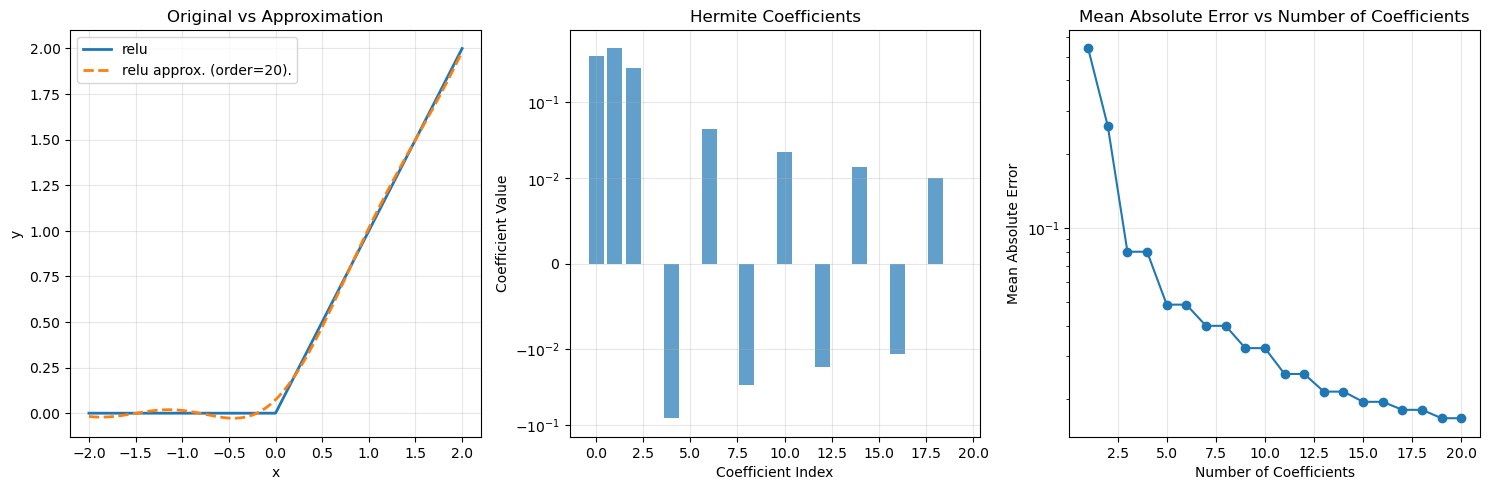

In [5]:

# View the Hermite approximation for well known activations 
act_name = 'relu'
plot_hermite_approximation_analysis(act_name, max_order=20)


In [6]:


def hermite_approximation_analysis(act_names, max_order=30):
    all_results = []
    for act_name in act_names:
        f = get_activation_function(act_name)
        coefs = compute_hermite_coefs_integration(f, order=max_order)
    
        x = np.linspace(-2, 2, 1000)
    
        mae_values = []
        for i in range(1, max_order + 1):
            f_approx = hermite_expansion(coefs[:i])
            mae = np.mean(np.abs(f(x)- f_approx(x)))
            mae_values.append(mae)
        all_results.append(mae_values)
    
    header = ['', '$\phi$'] + [f'k={k+1}' for k in range(max_order)] + ['']
    header = ' | '.join(header)
    print(header)
    print(' | '.join([''] + ['---' for k in range(max_order+1)]+['']))
    # all_results = hermite_approximation_analysis(act_names, max_order=max_order)
    for act,results in zip(act_names,all_results):
        s = ['', act] + [f'{r:.1e}' for r in results] + ['']
        s = ' | '.join(s)
        print(s)
    return all_results

max_order = 7
act_names = ['tanh', 'selu', 'relu', 'sigmoid', 'exp', 'gelu', 'celu', 'elu' ]
hermite_approximation_analysis(act_names, max_order=10);

 | $\phi$ | k=1 | k=2 | k=3 | k=4 | k=5 | k=6 | k=7 | k=8 | k=9 | k=10 | 
 | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | tanh | 6.6e-01 | 1.2e-01 | 1.2e-01 | 6.2e-02 | 6.2e-02 | 3.1e-02 | 3.1e-02 | 1.6e-02 | 1.6e-02 | 9.7e-03 | 
 | selu | 1.0e+00 | 1.1e-01 | 8.2e-02 | 5.1e-02 | 5.0e-02 | 3.4e-02 | 3.2e-02 | 2.7e-02 | 2.4e-02 | 2.2e-02 | 
 | relu | 5.4e-01 | 2.6e-01 | 8.0e-02 | 8.0e-02 | 4.9e-02 | 4.9e-02 | 4.0e-02 | 4.0e-02 | 3.2e-02 | 3.2e-02 | 
 | sigmoid | 2.2e-01 | 1.6e-02 | 1.6e-02 | 4.5e-03 | 4.5e-03 | 1.4e-03 | 1.4e-03 | 4.0e-04 | 4.0e-04 | 1.5e-04 | 
 | exp | 1.5e+00 | 7.2e-01 | 3.6e-01 | 2.1e-01 | 7.7e-02 | 2.9e-02 | 1.2e-02 | 3.6e-03 | 1.3e-03 | 4.0e-04 | 
 | gelu | 5.3e-01 | 2.7e-01 | 6.2e-02 | 6.2e-02 | 2.0e-02 | 2.0e-02 | 9.3e-03 | 9.3e-03 | 4.5e-03 | 4.5e-03 | 
 | celu | 7.9e-01 | 1.6e-01 | 5.1e-02 | 3.3e-02 | 2.7e-02 | 1.6e-02 | 1.5e-02 | 1.0e-02 | 9.7e-03 | 7.7e-03 | 
 | elu | 7.9e-01 | 1.6e-01 | 5.1e-02 | 3.3e-02 | 2.7e-02 | 1.6e-02 | 1.5e-02 

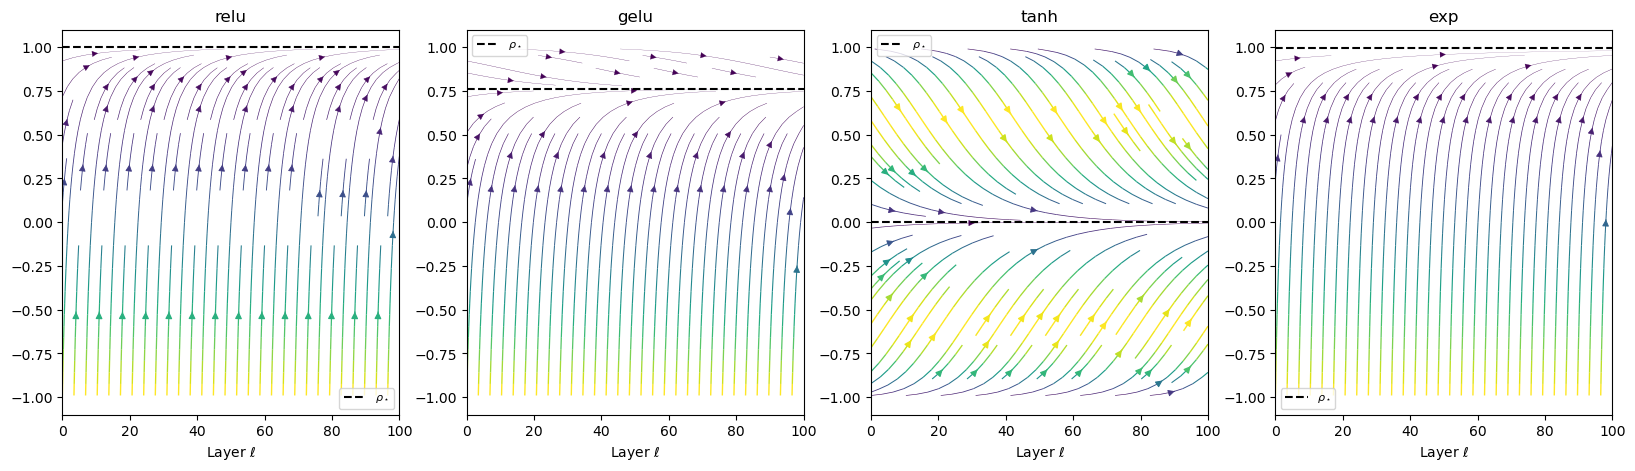

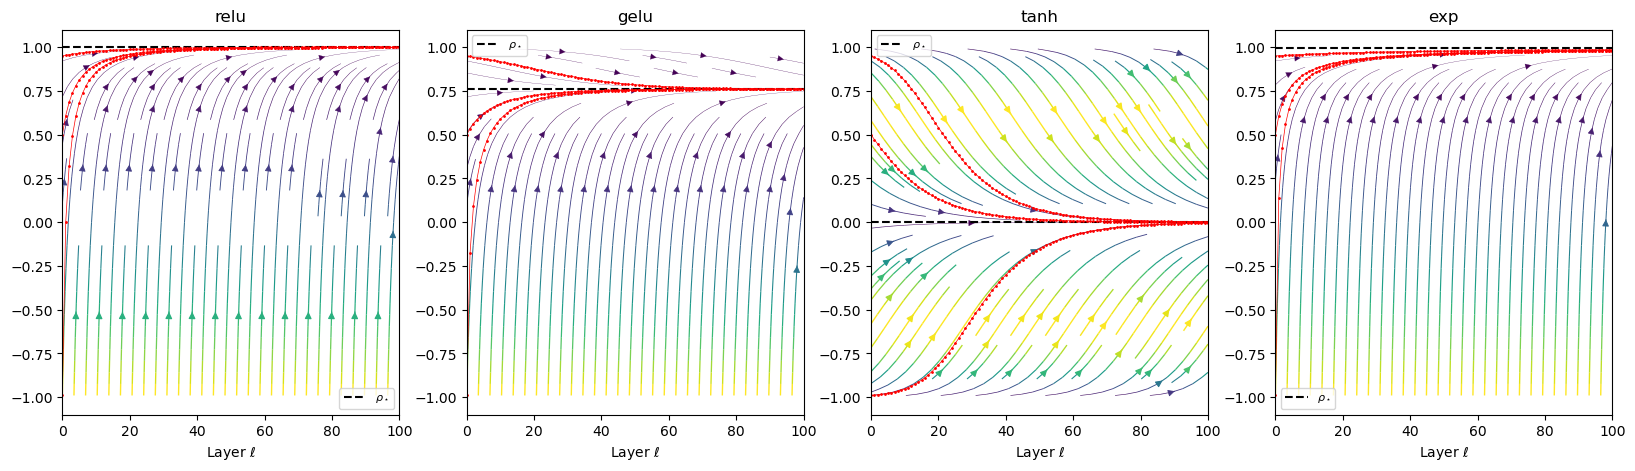

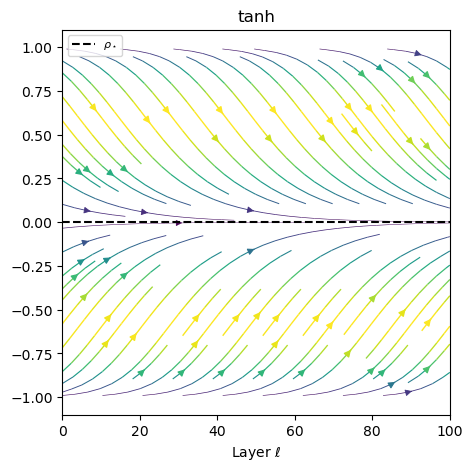

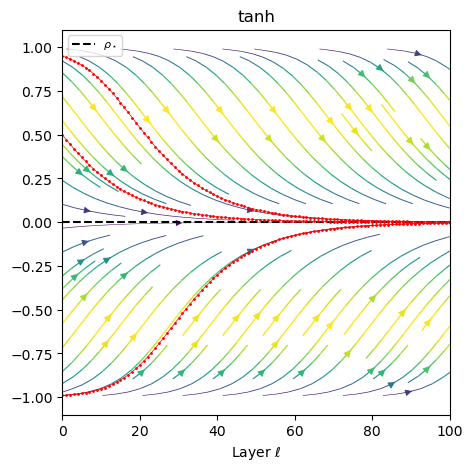

In [ ]:
# use plot_stream_plots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_stream_plots(axes, ['relu', 'gelu', 'tanh', 'exp'], f'{figures_path}/kernel_ODE.pdf', rho0s=[])

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_stream_plots(axes, ['relu', 'gelu', 'tanh', 'exp'], f'{figures_path}/kernel_ODE_fpi.pdf', rho0s=[-0.99, 0.5, 0.95])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plot_stream_plots(axes, ['relu', 'gelu', 'tanh', 'exp'], f'{figures_path}/kernel_ODE_fpi.pdf', rho0s=[-0.99, 0.5, 0.95])

for i, act in enumerate(['tanh']):
    ax = plt.figure(figsize=(5,5)).gca()
    stream_plot(ax, act, L=100, a=-0.99, b=.99,rho0s=[])
    ax.set_title(f'{act}')
    ax.set_xlabel('Layer $\\ell$')
    plt.savefig(f'{figures_path}/kernel_ode_{act}.pdf', format='pdf', bbox_inches='tight')

    ax = plt.figure(figsize=(5,5)).gca()
    stream_plot(ax, act, L=100, a=-0.99, b=.99,rho0s=[-.99, 0.5, 0.95])
    ax.set_title(f'{act}')
    ax.set_xlabel('Layer $\\ell$')
    plt.savefig(f'{figures_path}/kernel_ode_fpi_{act}.pdf', format='pdf', bbox_inches='tight')

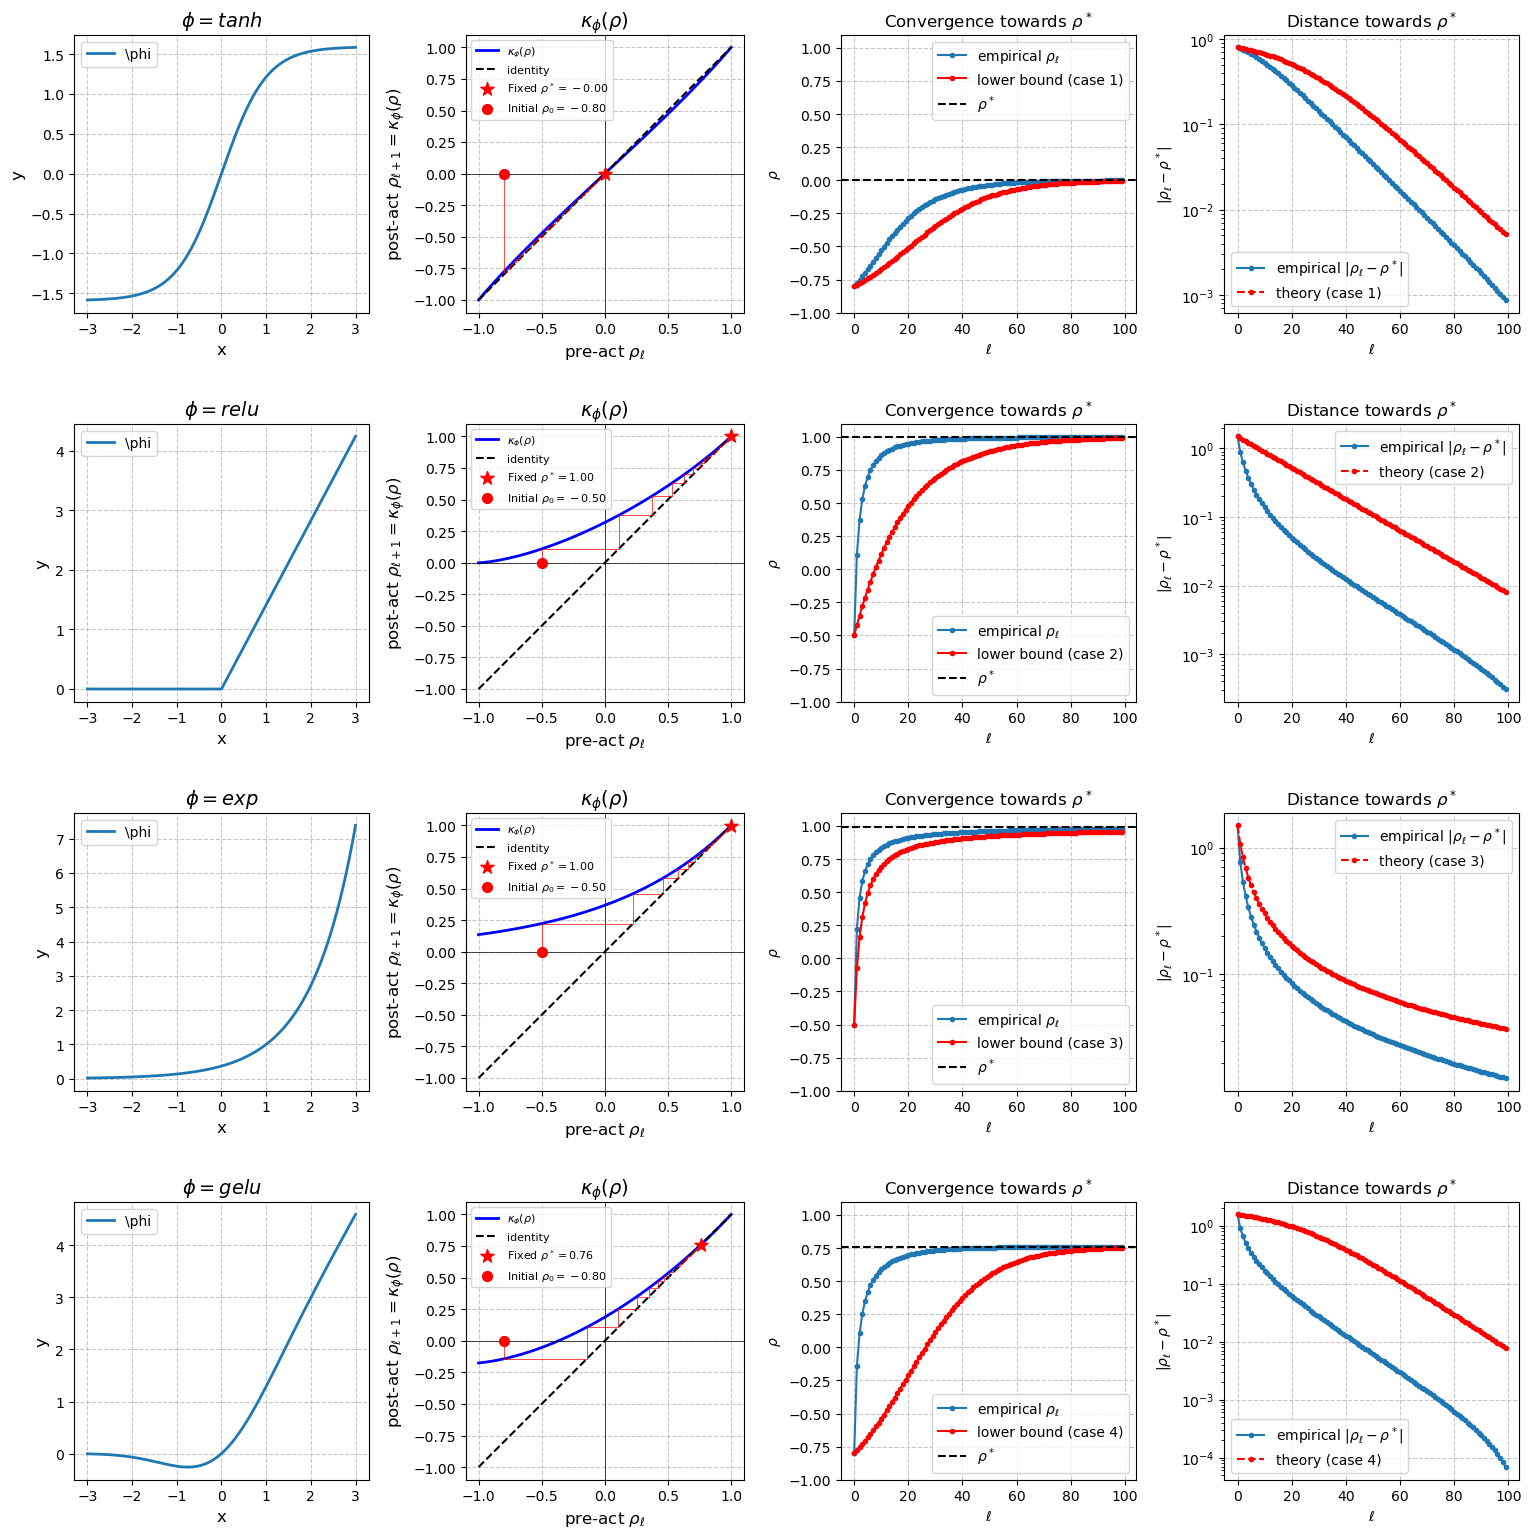

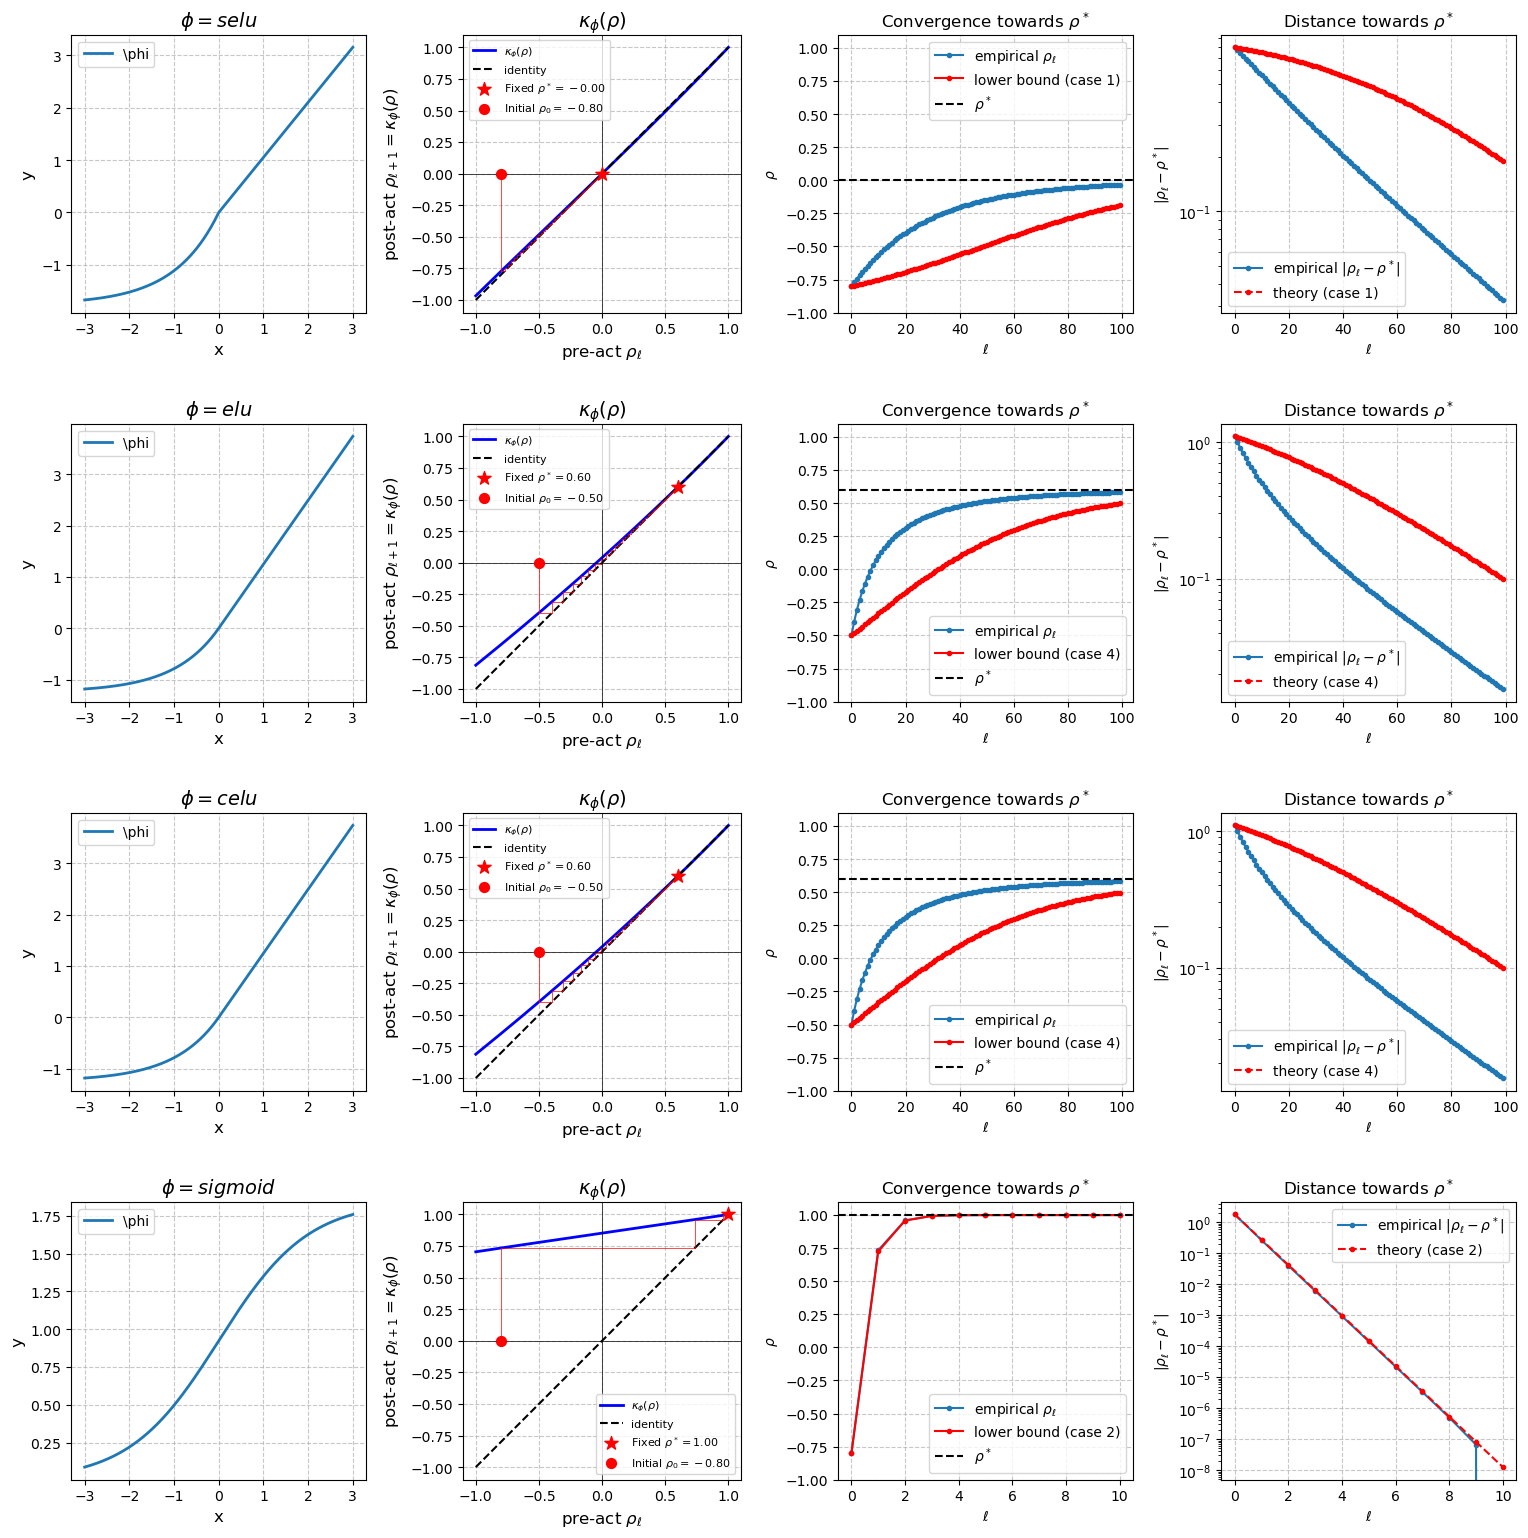

In [ ]:


act_init = [(-.8, 'tanh'), (-.5, 'relu'), (-.5, 'exp'), (-.8, 'gelu')]
plot_activation_comparisons(act_init, order=25, save_path=f'{figures_path}/kernel_convergence.pdf')

act_init = [(-.8, 'selu'), (-.5, 'elu'), (-.5, 'celu'), (-.8, 'sigmoid')]
plot_activation_comparisons(act_init, order=20, save_path=f'{figures_path}/kernel_convergence_2.pdf')


act_init = [(-.8, {'name':'leaky_relu','alpha':alpha})  for alpha in [0, 0.1, 0.2, 0.5]]
plot_activation_comparisons(act_init, order=50, save_path=f'{figures_path}/kernel_convergence_leaky_relu.pdf')


activation_names = ['tanh', 'relu', 'leaky_relu', 'exp', 'gelu', 'selu', 'celu', 'elu', 'sigmoid']
latex_table_string = generate_latex_table(activation_names)
print(latex_table_string)



# Rebuttal 

In [ ]:

stats = get_activation_indicators('relu',order=25)
stats = {k.replace('$','').replace('\\','') :v for k,v in stats.items()}
stats

In [ ]:
# standard imports 
import math 
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Literal, Optional, Tuple
import random
import numpy as np

# torch related imports 
import torch
import torch.nn as nn
from torch.nn import LayerNorm, RMSNorm
from typing import List, Union, Literal
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

def set_seed(seed: int):
    """Set all seeds to make results reproducible"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

class Activation(nn.Module):
    def __init__(self, name: str, num_samples=10_000_000, seed=None):
        super().__init__()
        if seed is not None:
            torch.manual_seed(seed)
            
        self.fn = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'selu': nn.SELU(),
            'tanh': nn.Tanh(),
            'celu': nn.CELU(),
            'elu': nn.ELU(),
            'exp': lambda x: torch.exp(x),
            'sigmoid': nn.Sigmoid()
        }[name]

        # scaling to ensure unit gain E f(X)^2 = 1 wrt Gaussian pre-activations 
        self.scale = 1.0 / math.sqrt(torch.mean(self.fn(torch.randn(num_samples))**2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fn(x) * self.scale

class Normalize(torch.nn.Module):
    """Transform that normalizes each input tensor to have RMS norm of 1."""
    def __init__(self, name: str):
        super().__init__()
        self.name = name

    def forward(self, x):
        # flatten inputs 
        x = x.view(x.size(0), -1)
        # if LayerNorm, reduce mean
        if self.name=='layer': 
            x = x - torch.mean(x,dim=1,keepdim=True)
        if self.name=='layer' or self.name=='rms':
            norms = torch.sqrt(torch.mean(x**2,dim=1,keepdim=True))
            x = x / norms
        return x

class MLPBlock(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        activation: str,
        norm_type: str,
        norm_position: Literal['pre', 'post'],
        weight_init: Literal['uniform', 'normal'],
        residual_strength: float,
        seed: Optional[int] = None
    ):
        super().__init__()
        
        if seed is not None:
            torch.manual_seed(seed)
            
        self.linear = nn.Linear(in_dim, out_dim)
        self.skip = nn.Linear(in_dim, out_dim, bias=False) if residual_strength != 0 else None
        self.residual_strength = residual_strength
        
        # scale by 1/ sqrt( outgoing dim)  to ensure contant pre-activations 
        init_scale = (1/in_dim)**0.5
        if weight_init == 'uniform':
            init_scale *= math.sqrt(3) # for uniform variables, to get unit variance we need to multiply by sqrt(3)
            nn.init.uniform_(self.linear.weight, -init_scale, init_scale)
            if self.skip is not None:
                nn.init.uniform_(self.skip.weight, -init_scale, init_scale)
        else:
            nn.init.normal_(self.linear.weight, std=init_scale)
            if self.skip is not None:
                nn.init.normal_(self.skip.weight, std=init_scale)
        nn.init.zeros_(self.linear.bias)
        
        self.norm = Normalize(norm_type)
        self.activation = Activation(activation, seed=seed)
        self.norm_first = norm_position == 'pre'

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.linear(x)
        
        if self.norm_first and self.norm:
            out = self.norm(out)
            out = self.activation(out)
        else:
            out = self.activation(out)
            if self.norm:
                out = self.norm(out)
        
        if self.skip is not None:
            r = self.residual_strength
            sqrt_1_r2 = (1 - r**2)**0.5
            out = sqrt_1_r2 * out + r * self.skip(x)
            
        return out

class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        output_dim: int,
        activation: str = 'relu',
        norm_type: Union[str, None] = None,
        norm_position: Literal['pre', 'post'] = 'post',
        weight_init: Literal['uniform', 'normal'] = 'uniform',
        residual_strength: float = 0.0,
        seed: Optional[int] = None
    ):
        super().__init__()
        
        if seed is not None:
            torch.manual_seed(seed)
            
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList([
            MLPBlock(
                in_dim=dims[i], 
                out_dim=dims[i + 1],
                activation=activation,
                norm_type=norm_type,
                norm_position=norm_position,
                weight_init=weight_init,
                residual_strength=residual_strength,
                seed=seed + i if seed is not None else None  # Different seed for each layer
            )
            for i in range(len(dims) - 1)
        ])
    
    def forward(self, x: torch.Tensor, return_hidden=False) -> torch.Tensor:
        hidden = [x.detach().cpu()]
        for layer in self.layers:
            x = layer(x)
            hidden.append(x.detach().cpu())
        if return_hidden:
            return x, hidden
        return x

def get_dataset(
    name: Literal['cifar10', 'cifar100', 'mnist'],
    batch_size: int,
    seed: Optional[int] = None,
) -> Tuple[DataLoader, DataLoader, int]:
    """
    Load and prepare the specified dataset with appropriate transforms.
    Returns train loader, test loader, input dimension, and number of classes.
    """
    if seed is not None:
        torch.manual_seed(seed)
        
    if name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            Normalize('rms'),
        ])
        input_dim = 28 * 28
        num_classes = 10
        
    else:  # CIFAR-10 or CIFAR-100
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465) if name == 'cifar10' else (0.5071, 0.4867, 0.4408),
                (0.2023, 0.1994, 0.2010) if name == 'cifar10' else (0.2675, 0.2565, 0.2761)
            ),
            Normalize('rms'),
        ])
        
        input_dim = 32 * 32 * 3
        num_classes = 10 if name == 'cifar10' else 100

    dataset_class = {
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100,
        'mnist': torchvision.datasets.MNIST,
    }[name]

    # Set generator for DataLoader
    generator = torch.Generator()
    if seed is not None:
        generator.manual_seed(seed)

    train_dataset = dataset_class(
        root='../data', train=True, download=True, transform=transform
    )
    test_dataset = dataset_class(
        root='../data', train=False, download=True, transform=transform
    )
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        generator=generator
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        generator=generator
    )
    
    return train_loader, test_loader, input_dim, num_classes

@dataclass
class Config:
    # Required arguments first
    dataset: Literal["cifar10", "cifar100", "mnist"]
    hidden_dims: List[int]
    input_dim: int = None
    output_dim: int = None
    
    # Optional arguments with defaults
    seed: int = 42
    device: str = "cpu"
    batch_size: int = 64
    activation: Literal["relu", "gelu", "silu", "tanh", "sigmoid", "selu","elu", "gelu"] = "relu"
    norm_type: Optional[Literal["layer", "rms"]] = None
    norm_position: Literal["pre", "post"] = "post"
    weight_init: Literal["uniform", "normal"] = "uniform"
    residual_strength: float = 0.0

    def get_loaders(self):
        train_loader, test_loader, input_dim, num_classes = get_dataset(
            self.dataset, 
            self.batch_size,
            seed=self.seed
        )
        self.input_dim = input_dim
        self.output_dim = num_classes
        return train_loader, test_loader

# Example usage:
if __name__ == "__main__":    
    config = Config(
        dataset="cifar100",
        hidden_dims=[1000,] * 105,
        batch_size=1000,
        activation="gelu",
        norm_type="rms",
        norm_position="post",
        weight_init="normal",
        residual_strength=0.0,
        device="cuda:0",
        seed=42  
    )
    # print(config, '\n'*2)

    all_results = []
    for activation in ['tanh', 'selu', 'relu', 'sigmoid', 'exp', 'gelu', 'celu', 'elu' ]:
    # for norm in ['rms', 'layer']:
    #     for norm_position in ['pre', 'post']:
    #         config.norm_type = norm
    #         config.norm_position = norm_position
            # print(f'normalization = {norm}, normalization position: {norm_position}\n')
            config.activation = activation
            
            results = []
            print(f"activation = {activation}")
            set_seed(config.seed) # Using the seed from config
            train_loader, test_loader = config.get_loaders()
    
            
            model = MLP(
                input_dim=config.input_dim,
                hidden_dims=config.hidden_dims,
                output_dim=config.output_dim,
                activation=config.activation,
                norm_type=config.norm_type,
                norm_position=config.norm_position,
                weight_init=config.weight_init,
                residual_strength=config.residual_strength,
                seed=config.seed
            ).to(config.device)
    
            for inputs, targets in train_loader:
                inputs = inputs.view(inputs.size(0), -1).to(config.device)
                targets = targets.to(config.device)
                break
    
            outputs, hidden = model(inputs, return_hidden=True)
            # print(f"Output shape: {outputs.shape}, Hidden shape: {hidden[1].shape}")
            
            for i in range(0,len(hidden),20):
                H = hidden[i]
                n, d = H.shape
                G = H @ H.t() / d
                diags = torch.diag(G,)
                dists = torch.triu(G,1)
                dists = dists[dists!=0].flatten()
                if i==0:
                    name = 'input'
                elif i==len(hidden)-1:
                    name = 'output'
                else:
                    name = f'layer {i}'
                if name == 'output':
                    continue
                results.append({
                    'layer':i, 
                    'off_diags_mean': dists.mean().item(), 'off_diags_std': dists.std().item(),
                    'diags_mean': diags.mean().item(), 'diags_std': diags.std().item(),
                })
                # print(f'{name:15} diags: {diags.mean().item():.3f} ± {diags.std().item():.3f}, off diags: {dists.mean().item():.3f} ± {dists.std().item():.3f}')
                print(f'{name:10} {dists.mean().item():.2f} ± {dists.std().item():.2f}')
                # print(f'{name:15} {diags.mean().item():.3f} ± {diags.std().item():.3f}')
            
        all_results.append((residual_strength,results))

